In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import random
from fastai import *
from fastai.vision import *

In [2]:
# ref: https://github.com/rois-codh/kmnist
# Kuzushiji-MNIST contains 70,000 28x28 grayscale images 
# spanning 10 classes (one from each column of hiragana), 
# and is perfectly balanced like the original MNIST dataset (6k/1k train/test for each class).

# raw data, urls: x_train, x_test, y_train, y_test
xtrain_url = 'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz'
xtest_url = 'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz'
ytrain_url = 'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz'
ytest_url = 'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'
# mapping from class index to japanese characters
classes = pd.read_csv('http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist_classmap.csv')

In [1]:
classes

NameError: name 'classes' is not defined

In [4]:
def download_kmnist(url):
    print('Processing {}...'.format(url.split('/')[-1]))
    send_req = requests.get(url, stream = True)
    load_raw = np.load(BytesIO(send_req.raw.read()))
    load_data = torch.from_numpy(load_raw['arr_0'])
    print('Done.')
    return load_data

def process_imgs(array):
    array = array.type(torch.float32)
    mean, std = array.mean(), array.std()
    array = (array-mean) / std
    array = array.reshape(-1, 1, 28, 28)
    # kmnist images have single channel
    array = np.repeat(array, 3, axis=1)
    return array

def process_lbls(array):
    return array.type(torch.LongTensor)
    
def show_img(images_tensor, labels_tensor, class_map, channel, random_index=True):
    """
    images_tensor: kmnist post-processed images tensor
    labels_tensor: label tensor
    class_map: label/hiragana mapping
    channel: int 0,1,2 (rgb)
    random_index: if false: index=0
    """
    
    if len(images_tensor) != len(labels_tensor):
        raise Exception('Image/Labels tensors mismatch')
        
    if channel < 0 or channel > 2:
        raise Exception('Channel must be 0, 1 or 2')
    
    if random_index:
        index = random.randint(0, len(images_tensor)-1)
        img = images_tensor[index][channel]
    else:
        index = 0
        img = images_tensor[index][channel]
    
    print('Label: {}'.format(labels_tensor[index]), \
          ' corresponds to character: {}'.format(class_map.loc[int(labels_tensor[index])]['char']))
    
    plt.figure(figsize=(2,2))
    plt.imshow(img, cmap = 'RdPu')
    plt.show()
    return

class Zip(Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y
        # check on c
        self.c = len(np.unique(y))
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [5]:
x_train = process_imgs(download_kmnist(xtrain_url))
x_test = process_imgs(download_kmnist(xtest_url))
y_train = process_lbls(download_kmnist(ytrain_url))
y_test = process_lbls(download_kmnist(ytest_url))

Processing kmnist-train-imgs.npz...
Done.
Processing kmnist-test-imgs.npz...
Done.
Processing kmnist-train-labels.npz...
Done.
Processing kmnist-test-labels.npz...
Done.


In [6]:
train_data = Zip(x_train, y_train)
valid_data = Zip(x_test, y_test)
data = DataBunch.create(train_data, valid_data, bs=64)

bins:  tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])
sample image:
Label: 8  corresponds to character: れ


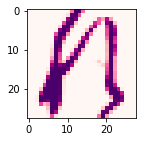

In [7]:
# classes in kmnist are balanced
print('bins: ', y_train.bincount())
print('sample image:')
show_img(x_train, y_train, classes, channel=1, random_index=False)

In [8]:
# setup model
# check crossE
learn = cnn_learner(data, models.resnet34, loss_func=CrossEntropyFlat(), metrics=accuracy)

In [9]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.234233,1.389896,0.572500,00:30
1,0.666453,0.935814,0.709600,00:29
2,0.406480,0.603698,0.813000,00:30
3,0.262995,0.422262,0.875200,00:31
4,0.191652,0.356016,0.890600,00:30
5,0.171702,0.314882,0.904300,00:31
6,0.149604,0.277875,0.914300,00:32
7,0.121155,0.267344,0.920800,00:32
8,0.112515,0.262326,0.922200,00:32
9,0.103997,0.261937,0.921900,00:32


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


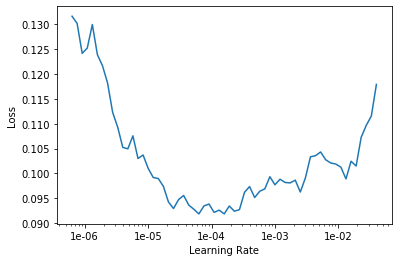

In [10]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.091790,0.155305,0.953500,00:51
1,0.036802,0.103513,0.973300,00:52
